In [361]:
!pip install networkx

Defaulting to user installation because normal site-packages is not writeable


In [362]:
import matplotlib.pyplot as plt
import networkx as nx

In [363]:
# Define a function to convert to Hasse diagram by removing redundant edges
def to_hasse_diagram(graph):
    # Removing loops
    edges_to_remove = [(node, node) for node in graph.nodes()]

    for u, v in graph.edges():
        # Check if there's a path from u to v with an intermediate node
        for w in graph.nodes():
            if w != u and w != v and nx.has_path(graph, u, w) and nx.has_path(graph, w, v):
                edges_to_remove.append((u, v))

    hasse = nx.Graph(graph)
    hasse.remove_edges_from(edges_to_remove)
    print(f"Removing {edges_to_remove}")

    predecessors = {node: 0 for node in graph.nodes()}
    for n1, n2 in itertools.product(graph.nodes(), graph.nodes()):
        if n1 == n2:
            continue
        # Checking whether n2 is a predecessot of n1
        if nx.has_path(graph, n2, n1):
            predecessors[n1] += 1

    
    depths = predecessors.copy()
    sorted_predecessors = sorted(list(set(depths.values())))
    for node, depth in depths.items():
        if depth != 0:
            index = sorted(list(set(depths.values()))).index(depth)
            nodes_below = list(filter(lambda node: node[1] == sorted_predecessors[index - 1], depths.items()))
            if not any(nx.has_path(graph, node_below, node) for node_below, d in nodes_below):
                depths[node] = nodes_below[0][1]
    return hasse, depths
    

def to_poset(graph):
    directed_graph = nx.DiGraph()
    directed_graph.add_nodes_from(graph.nodes())
    directed_graph.add_edges_from([(n2, n1) for n1, n2 in graph.edges()])
    poset = nx.DiGraph()
    
    edges = []
    for n1, n2 in itertools.product(directed_graph.nodes(), repeat=2):
        if nx.has_path(directed_graph, n1, n2):
            edges.append((n1, n2))
    
    poset.add_nodes_from(nodes)
    poset.add_edges_from(edges)
    return poset
    

def calculate_pos(predecessors):
    pos = {}
    for node, depth in predecessors.items():
        if not any(y == depth for _, y in pos.values()):
            pos[node] = (0, depth)
        else:
            m = max([coords[0] for coords in pos.values() if coords[1] == depth])
            pos[node] = (m + 1, depth)
    return pos


def find_infinum(graph, subset):
    # Find the lower bounds
    common_predecessors = set.intersection(
        *(set(nx.ancestors(graph, node)).union({node}) for node in subset)
    )
    infinum = max(common_predecessors, default=None, key=lambda x: graph.in_degree(x))
    if infinum:
        # print(f"Infinum: {infinum}")
        # In order to be the greatest lower bound all lower bounds must be connected to it and be its ancestors
        if all(nx.has_path(graph, p, infinum) for p in common_predecessors):
            return infinum


def find_supremum(graph, subset):
    # Find the upper bounds
    common_descendants = set.intersection(
        *(set(nx.descendants(graph, node)).union({node}) for node in subset)
    )
    supremum = max(common_descendants, default=None, key=lambda x: graph.out_degree(x))
    if supremum:
        # print(f"Supremum {supremum}")
        # in order to be the least upper bound all upper bounds must be conencted to it and be its descendants
        if all(nx.has_path(graph, supremum, d) for d in common_descendants):
            return supremum


def find_complement(graph, node):
    max_node = next(filter(lambda n: graph.out_degree(n) == 1, graph.nodes()))
    root = next(filter(lambda n: graph.in_degree(n) == 1, graph.nodes()))
    for n in graph.nodes():
        if n == node:
            continue
        supremum = find_supremum(graph, (node, n))
        infinum = find_infinum(graph, (node, n))
        if infinum == root and supremum == max_node:
            return n

def is_lattice(graph):
    for subset in itertools.combinations(graph.nodes(), 2):
        print(f"Checking {subset} subset")
        infinum = find_infinum(graph, subset)
        supremum = find_supremum(graph, subset)
        if not (infinum and supremum):
            print(f"Subset {subset} does not have infinum or supremum")
            return False
    return True


def is_complementary(graph):
    return all(find_complement(graph, node) for node in graph.nodes())
    
        
def draw_graph(graph, ax, pos=None):
    pos = pos or nx.spring_layout(graph)
    nx.draw(graph, pos, with_labels=True, node_color='lightblue', node_size=2000, font_size=10, font_weight='bold', ax=ax, edge_color='black')

# Conversion from POSET to Hasse diagram 

Validity of pairs:
('c', 'e'): Invalid
('e', 'c'): Invalid
Removing [('a', 'a'), ('b', 'b'), ('c', 'c'), ('d', 'd'), ('e', 'e'), ('c', 'a'), ('c', 'a'), ('e', 'a')]


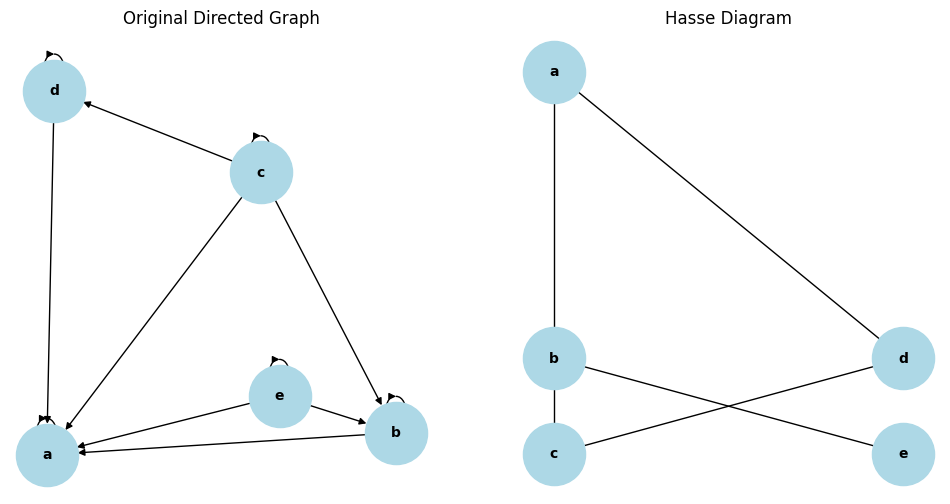

In [364]:
# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges
nodes = ['a', 'b', 'c', 'd', 'e']
edges = [(n, n) for n in nodes]
edges += [('e', 'a'), ('e', 'b'), ('b', 'a'), ('c', 'a'), ('c', 'b'),
        ('c', 'd'), ('d', 'a')]

G.add_nodes_from(nodes)
G.add_edges_from(edges)

# Define a function to check if a pair (x, y) is valid
def is_valid_pair(graph, x, y):
    return nx.has_path(graph, x, y)

# Test pairs
pairs = [('c', 'e'), ('e', 'c')]
results = {pair: is_valid_pair(G, *pair) for pair in pairs}

# Display the results
print("Validity of pairs:")
for pair, valid in results.items():
    print(f"{pair}: {'Valid' if valid else 'Invalid'}")
    
H, depths = to_hasse_diagram(G)

# Create a figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

draw_graph(G, axes[0])
axes[0].set_title("Original Directed Graph")
    
draw_graph(H, axes[1], calculate_pos(depths))
axes[1].set_title("Hasse Diagram")

# plt.tight_layout()
plt.show()

# Conversion from Hasse to POSET 

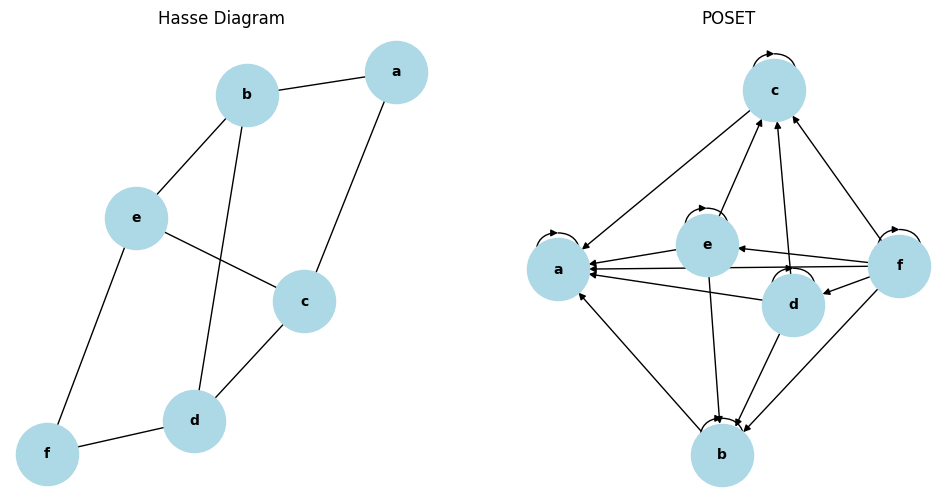

In [365]:
# Conversion from POSET to hasse diagram 

G = nx.Graph()

# nodes = ['a', 'b', 'c', 'd', 'e']
# edges = [('c', 'b'), ('c', 'd'), ('e', 'b'), ('b', 'a'), ('d', 'a')]

# nodes = ['a', 'b', 'c', 'd']
# edges = [('d', 'b'), ('d', 'c'), ('b', 'a'), ('c', 'a')]

# nodes = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i']
# edges = [('i', 'h'), ('i', 'g'), ('g', 'd'), ('g', 'e'),
#         ('h', 'e'), ('h', 'f'), ('d', 'b'), ('e', 'b'),
#         ('e', 'c'), ('f', 'c'), ('b', 'a'), ('c', 'a')]

# nodes = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i']
# edges = [('i', 'h'), ('i', 'g'), ('g', 'd'), ('g', 'e'),
#         ('h', 'e'), ('h', 'f'), ('d', 'b'), ('f', 'c'), ('b', 'a'), ('c', 'a')]

# nodes = ['a', 'b', 'c', 'd', 'e']
# edges = [('e', 'd'), ('e', 'c'), ('c', 'a'), ('d', 'b'), ('b', 'a')]

nodes = ['a', 'b', 'c', 'd', 'e', 'f']
edges = [('f', 'd'), ('f', 'e'), ('d', 'b'), ('d', 'c'), ('e', 'c'), ('e', 'b'), ('b', 'a'), ('c', 'a')]

G.add_nodes_from(nodes)
G.add_edges_from(edges)
    
P = to_poset(G)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

draw_graph(
    G, 
    axes[0], 
    # pos={'c': (0, 0), 'e': (1, 0), 'b': (0, 1), 'd': (1, 1), 'a': (0, 2)}
)
axes[0].set_title("Hasse Diagram")
    
draw_graph(P, axes[1])
axes[1].set_title("POSET")

plt.show()

## Find whether it's a lattice or not

In [366]:
print(G.edges())
print(f"Graph is a lattice: {'YES' if is_lattice(P) else 'NO'}")

[('a', 'b'), ('a', 'c'), ('b', 'd'), ('b', 'e'), ('c', 'd'), ('c', 'e'), ('d', 'f'), ('e', 'f')]
Checking ('a', 'b') subset
Checking ('a', 'c') subset
Checking ('a', 'd') subset
Checking ('a', 'e') subset
Checking ('a', 'f') subset
Checking ('b', 'c') subset
Subset ('b', 'c') does not have infinum or supremum
Graph is a lattice: NO


## Find whether it's complementary

In [367]:
from random import choice
random_node = choice(list(P.nodes()))
print(f"The complementary of {random_node} is {find_complement(P, random_node)}")
print(f"Graph is complementary: {'YES' if is_complementary(P) else 'NO'}")

The complementary of f is a
Graph is complementary: NO
